In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=97615e4b21679c22bea120b535b39e21bb498adcdf094fae034770eeec31b447
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


# **VVVVVVVVV**

# Library Load & Data Load

In [ ]:
# Basic Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Spark Library
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql import SQLContext, Window
import pyspark.sql.functions as F
from pyspark.sql.functions import mean,col,split,regexp_extract, when, lit,max,min,isnan,count, desc,var_samp,avg
from pyspark.ml.feature import StringIndexer, VectorAssembler
# StringIndexer: mapping of string column of label to an ML column of label indice
# VectorAssembler: merge multiple column vector to single column
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import LinearRegression

In [ ]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
spark_session = SparkSession.builder.master("local[2]").appName("HousingRegression").getOrCreate()

In [ ]:
  from google.colab import drive
  drive.mount("/content/drive")
  %cd "drive/My Drive/ColabNotebooks/comp4651_proj"
#data_dir='./'

Mounted at /content/drive
/content/drive/My Drive/ColabNotebooks/comp4651_proj


In [ ]:
# load the dataset and create spark dataframe
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
#train =  pd.read_csv(data_dir+'train.csv',index_col='Id')
#test = pd.read_csv(data_dir+'test.csv',index_col='Id')
train_df = spark_session.createDataFrame(train)
test_df = spark_session.createDataFrame(test)

# limit 5, like pandas head function
# toPandas make Pyspark DataFrame as Pandas table
train_df.limit(5).toPandas()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
print(train_df.select([(count(when(isnan(c), c))/count("Id")).alias(c) for c in train_df.columns]).show())
# print(train_df.select("Fence").show())

+---+----------+--------+------------------+-------+------+------------------+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+--------------------+--------------------+---------+---------+----------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+----------+---------+-----------+-------+---------+----------+--------------------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+------------------+-------------------+-------------------+-------------------+----------+----------+-------------------+-------------------+----------+----------+-----------+-------------+---------+-----------+--------+------------------+------------------+-----------------+-------+------+-----

In [ ]:
train_df=train_df.drop('Alley').drop('PoolQC').drop('Fence').drop('MiscFeature')
train_df.limit(5).show()

+---+----------+--------+-----------+-------+------+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+-------+------+------+--------+-------------+---------+
| Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition2|BldgType|HouseStyle|OverallQual|Ove

In [ ]:
def encodeRating(df):
    df=df.withColumn("LotShape",when(col("LotShape")=="Reg",0).when(col("LotShape")=="IR1",1).when(col("LotShape")=="IR2",2).when(col("LotShape")=="IR3",3))
    df=df.withColumn("Utilities",when(col("Utilities")=="AllPub",3).when(col("Utilities")=="NoSewr",2).when(col("Utilities")=="NoSeWa",1).when(col("Utilities")=="ELO",0))
    df=df.withColumn("LandSlope",when(col("LandSlope")=="Gtl",0).when(col("LandSlope")=="Mod",1).when(col("LandSlope")=="Sev",2))
    df=df.withColumn("ExterQual",when(col("ExterQual")=="Ex",4).when(col("ExterQual")=="Gd",3).when(col("ExterQual")=="TA",2).when(col("ExterQual")=="Fa",1).when(col("ExterQual")=="Po",0))
    df=df.withColumn("ExterCond",when(col("ExterCond")=="Ex",4).when(col("ExterCond")=="Gd",3).when(col("ExterCond")=="TA",2).when(col("ExterCond")=="Fa",1).when(col("ExterCond")=="Po",0))
    df=df.withColumn("BsmtQual",when(col("BsmtQual")=="Ex",5).when(col("BsmtQual")=="Gd",4).when(col("BsmtQual")=="TA",3).when(col("BsmtQual")=="Fa",2).when(col("BsmtQual")=="Po",1).otherwise(0))
    df=df.withColumn("BsmtCond",when(col("BsmtCond")=="Ex",5).when(col("BsmtCond")=="Gd",4).when(col("BsmtCond")=="TA",3).when(col("BsmtCond")=="Fa",2).when(col("BsmtCond")=="Po",1).otherwise(0))
    df=df.withColumn("BsmtExposure",when(col("BsmtExposure")=="Gd",4).when(col("BsmtExposure")=="Av",3).when(col("BsmtExposure")=="Mn",2).when(col("BsmtExposure")=="No",1).otherwise(0))
    df=df.withColumn("BsmtFinType1",when(col("BsmtFinType1")=="GLQ",6).when(col("BsmtFinType1")=="ALQ",5).when(col("BsmtFinType1")=="BLQ",4).when(col("BsmtFinType1")=="Rec",3).when(col("BsmtFinType1")=="LwQ",2).when(col("BsmtFinType1")=="Unf",1).otherwise(0))
    df=df.withColumn("BsmtFinType2",when(col("BsmtFinType2")=="GLQ",6).when(col("BsmtFinType2")=="ALQ",5).when(col("BsmtFinType2")=="BLQ",4).when(col("BsmtFinType2")=="Rec",3).when(col("BsmtFinType2")=="LwQ",2).when(col("BsmtFinType2")=="Unf",1).otherwise(0))
    df=df.withColumn("HeatingQC",when(col("HeatingQC")=="Ex",4).when(col("HeatingQC")=="Gd",3).when(col("HeatingQC")=="TA",2).when(col("HeatingQC")=="Fa",1).otherwise(0))
    df=df.withColumn("CentralAir",when(col("CentralAir")=="N",0).when(col("CentralAir")=="Y",1))
    df=df.withColumn("Electrical",when(col("Electrical")=="SBrkr",4).when(col("Electrical")=="FuseA",3).when(col("Electrical")=="FuseF",2).when(col("Electrical")=="FuseP",1).otherwise(0))
    df=df.withColumn("KitchenQual",when(col("KitchenQual")=="Ex",4).when(col("KitchenQual")=="Gd",3).when(col("KitchenQual")=="TA",2).when(col("KitchenQual")=="Fa",1).otherwise(0))
    df=df.withColumn("Functional",when(col("Functional")=="Typ",6).when(col("Functional")=="Min1",6).when(col("Functional")=="Min2",5).when(col("Functional")=="Mod",4).when(col("Functional")=="Maj1",3).when(col("Functional")=="Maj2",2).when(col("Functional")=="Sev",1).when(col("Functional")=="Sal",0))
    df=df.withColumn("FireplaceQu",when(col("FireplaceQu")=="Ex",5).when(col("FireplaceQu")=="Gd",4).when(col("FireplaceQu")=="TA",3).when(col("FireplaceQu")=="Fa",2).when(col("FireplaceQu")=="Po",1).otherwise(0))
    df=df.withColumn("GarageFinish",when(col("GarageFinish")=="Fin",3).when(col("GarageFinish")=="RFn",2).when(col("GarageFinish")=="Unf",1).otherwise(0))
    df=df.withColumn("GarageQual",when(col("GarageQual")=="Ex",5).when(col("GarageQual")=="Gd",4).when(col("GarageQual")=="TA",3).when(col("GarageQual")=="Fa",2).when(col("GarageQual")=="Po",1).otherwise(0))
    df=df.withColumn("GarageCond",when(col("GarageCond")=="Ex",5).when(col("GarageCond")=="Gd",4).when(col("GarageCond")=="TA",3).when(col("GarageCond")=="Fa",2).when(col("GarageCond")=="Po",1).otherwise(0))
    df=df.withColumn("PavedDrive",when(col("PavedDrive")=="Y",2).when(col("PavedDrive")=="P",1).when(col("PavedDrive")=="N",0))

    return df

def getAvg(df,feat):
    a=df.groupBy(feat).avg("SalePrice")
    # v=df.groupBy(feat).agg(var_samp("SalePrice"))
    # r=a.join(v,feat)
    return a

def encodeTarget(df,avg_df):
    df=df.join(avg_df,"MSSubClass")
    return df


In [ ]:
cat_feat=['MSSubClass','MSZoning','Street','LandContour','LotConfig',\
          'Neighborhood','Condition1','Condition2','BldgType','HouseStyle',\
          'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType',\
          'Foundation','Heating','GarageType','SaleType','SaleCondition']
numerical_feat=[x for x in train_df.columns if (x not in cat_feat)]

In [ ]:
train_df=encodeRating(train_df)
train_df.limit(5).show()
print(train_df.select([count(when(isnan(c), c)).alias(c) for c in train_df.columns]).show())


+---+----------+--------+-----------+-------+------+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+-------+------+------+--------+-------------+---------+
| Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition2|BldgType|HouseStyle|OverallQual|Ove

In [ ]:
avg_MSSubClass=getAvg(train_df,"MSSubClass")
avg_MSZoning=getAvg(train_df,"MSZoning")
avg_Neighborhood=getAvg(train_df,"Neighborhood")
avg_MSSubClass.sort(desc("avg(SalePrice)")).show()
train_df=train_df.join(avg_MSSubClass,"MSSubClass").join(avg_MSZoning,"MSZoning").join(avg_Neighborhood,"Neighborhood")
train_df.limit(5).toPandas()

+----------+------------------+
|MSSubClass|    avg(SalePrice)|
+----------+------------------+
|        60| 239948.5016722408|
|       120| 200779.0804597701|
|        75|          192437.5|
|        20|185224.81156716417|
|        80|169736.55172413794|
|        70|166772.41666666666|
|        40|          156125.0|
|        85|          147810.0|
|        50|143302.97222222222|
|       160|138647.38095238095|
|        90|133541.07692307694|
|       190|129613.33333333333|
|        45|108591.66666666667|
|       180|          102300.0|
|        30| 95829.72463768115|
+----------+------------------+



,Neighborhood,MSZoning,MSSubClass,Id,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,...,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,avg(SalePrice),avg(SalePrice),avg(SalePrice)
0,Mitchel,RL,50,6,85.0,14115,Pave,1,Lvl,3,...,0,700,10,2009,WD,Normal,143000,143302.972222,191004.994787,156270.122449
1,OldTown,RM,50,9,51.0,6120,Pave,0,Lvl,3,...,0,0,4,2008,WD,Abnorml,129900,143302.972222,126316.830275,128225.300885
2,Mitchel,RL,50,47,48.0,12822,Pave,1,Lvl,3,...,0,0,8,2009,WD,Abnorml,239686,143302.972222,191004.994787,156270.122449
3,BrkSide,RM,50,52,52.0,6240,Pave,0,Lvl,3,...,0,400,9,2006,WD,Normal,114500,143302.972222,126316.830275,124834.051724
4,ClearCr,RL,50,70,81.0,15593,Pave,0,Lvl,3,...,0,0,7,2006,WD,Normal,225000,143302.972222,191004.994787,212565.428571


<Axes: title={'center': 'SalePrice'}, xlabel='[HouseStyle]'>

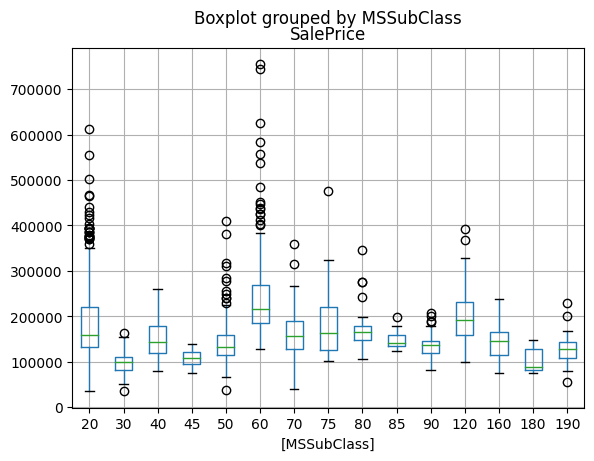

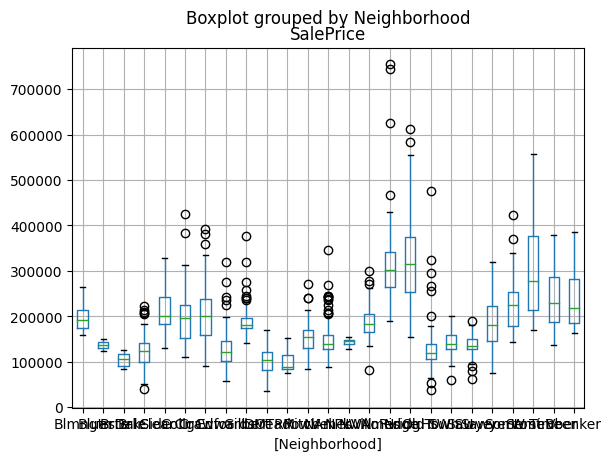

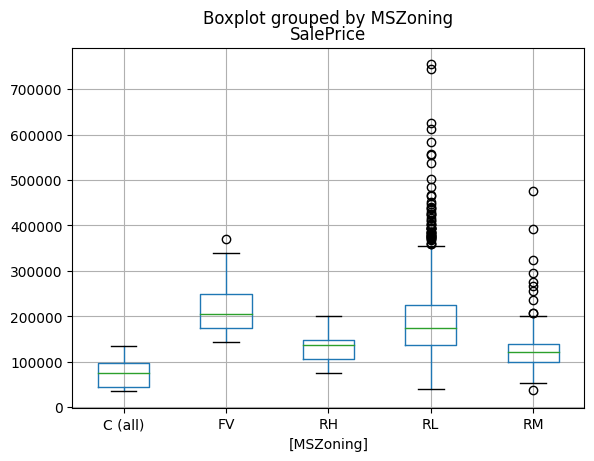

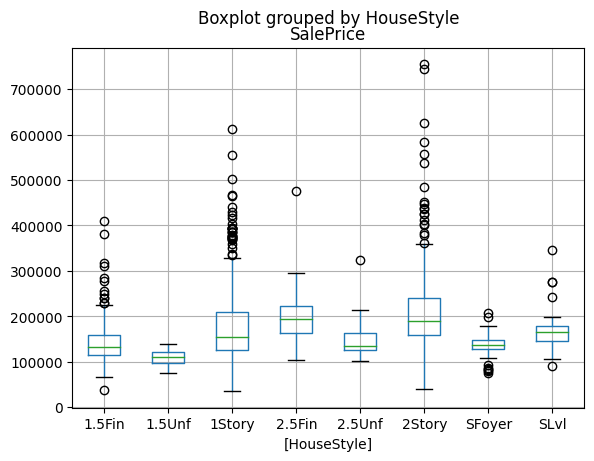

In [ ]:
train_df.toPandas().boxplot(column=['SalePrice'],by=['MSSubClass'])
train_df.toPandas().boxplot(column=['SalePrice'],by=['Neighborhood'])
train_df.toPandas().boxplot(column=['SalePrice'],by=['MSZoning'])
train_df.toPandas().boxplot(column=['SalePrice'],by=['HouseStyle'])

#  **^^^^^^^^**

In [ ]:
train_df = spark_session.createDataFrame(train)
train_df.describe().toPandas()

,summary,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,count,1460,1460,1460,1460,1460,1460,1460,1460,1460,...,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
1,mean,730.5,56.897260273972606,None,NaN,10516.828082191782,None,NaN,None,None,...,2.758904109589041,NaN,NaN,NaN,43.489041095890414,6.321917808219178,2007.8157534246575,None,None,180921.19589041095
2,stddev,421.6100093688479,42.300570993810425,None,NaN,9981.264932379145,None,NaN,None,None,...,40.177306944530194,NaN,NaN,NaN,496.1230244579442,2.7036262083595126,1.328095120552125,None,None,79442.5028828866
3,min,1,20,C (all),21.0,1300,Grvl,Grvl,IR1,Bnk,...,0,Ex,GdPrv,Gar2,0,1,2006,COD,Abnorml,34900
4,max,1460,190,RM,NaN,215245,Pave,Pave,Reg,Lvl,...,738,NaN,NaN,TenC,15500,12,2010,WD,Partial,755000


Data fields
Here's a brief version of what you'll find in the data description file.

- SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
- MSSubClass: The building class
- MSZoning: The general zoning classification
- LotFrontage: Linear feet of street connected to property
- LotArea: Lot size in square feet
- Street: Type of road access
- Alley: Type of alley access
- LotShape: General shape of property
- LandContour: Flatness of the property
- Utilities: Type of utilities available
- LotConfig: Lot configuration
- LandSlope: Slope of property
- Neighborhood: Physical locations within Ames city limits
- Condition1: Proximity to main road or railroad
- Condition2: Proximity to main road or railroad (if a second is present)
- BldgType: Type of dwelling
- HouseStyle: Style of dwelling
- OverallQual: Overall material and finish quality
- OverallCond: Overall condition rating
- YearBuilt: Original construction date
- YearRemodAdd: Remodel date
- RoofStyle: Type of roof
- RoofMatl: Roof material
- Exterior1st: Exterior covering on house
- Exterior2nd: Exterior covering on house (if more than one material)
- MasVnrType: Masonry veneer type
- MasVnrArea: Masonry veneer area in square feet
- ExterQual: Exterior material quality
- ExterCond: Present condition of the material on the exterior
- Foundation: Type of foundation
- BsmtQual: Height of the basement
- BsmtCond: General condition of the basement
- BsmtExposure: Walkout or garden level basement walls
- BsmtFinType1: Quality of basement finished area
- BsmtFinSF1: Type 1 finished square feet
- BsmtFinType2: Quality of second finished area (if present)
- BsmtFinSF2: Type 2 finished square feet
- BsmtUnfSF: Unfinished square feet of basement area
- TotalBsmtSF: Total square feet of basement area
- Heating: Type of heating
- HeatingQC: Heating quality and condition
- CentralAir: Central air conditioning
- Electrical: Electrical system
- 1stFlrSF: First Floor square feet
- 2ndFlrSF: Second floor square feet
- LowQualFinSF: Low quality finished square feet (all floors)
- GrLivArea: Above grade (ground) living area square feet
- BsmtFullBath: Basement full bathrooms
- BsmtHalfBath: Basement half bathrooms
- FullBath: Full bathrooms above grade
- HalfBath: Half baths above grade
- Bedroom: Number of bedrooms above basement level
- Kitchen: Number of kitchens
- KitchenQual: Kitchen quality
- TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
- Functional: Home functionality rating
- Fireplaces: Number of fireplaces
- FireplaceQu: Fireplace quality
- GarageType: Garage location
- GarageYrBlt: Year garage was built
- GarageFinish: Interior finish of the garage
- GarageCars: Size of garage in car capacity
- GarageArea: Size of garage in square feet
- GarageQual: Garage quality
- GarageCond: Garage condition
- PavedDrive: Paved driveway
- WoodDeckSF: Wood deck area in square feet
- OpenPorchSF: Open porch area in square feet
- EnclosedPorch: Enclosed porch area in square feet
- 3SsnPorch: Three season porch area in square feet
- ScreenPorch: Screen porch area in square feet
- PoolArea: Pool area in square feet
- PoolQC: Pool quality
- Fence: Fence quality
- MiscFeature: Miscellaneous feature not covered in other categories
- MiscVal: Value of miscellaneous feature
- MoSold: Month Sold
- YrSold: Year Sold
- SaleType: Type of sale
- SaleCondition: Condition of sale

In [ ]:
# withColumn can be used to change the value of dataFrame
train_df = train_df.withColumn("SaleCondition",when(train_df.SaleCondition == "Normal",0).when(train_df.SaleCondition == "Abnorml",1))
train_df.limit(5).toPandas()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,0,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,0,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,0,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,1,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,0,250000


In [ ]:
train_df.printSchema()

root
 |-- Id: long (nullable = true)
 |-- MSSubClass: long (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: double (nullable = true)
 |-- LotArea: long (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: long (nullable = true)
 |-- OverallCond: long (nullable = true)
 |-- YearBuilt: long (nullable = true)
 |-- YearRemodAdd: long (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |-- Exterior2nd: string 

# EDA using PySpark

In [ ]:
from pyspark.sql.types import StringType
# Check DataFrame's column dataType is string
cols = [f.name for f in train_df.schema.fields if isinstance(f.dataType, StringType)]

# Drop String type column
train_df.drop(*cols).printSchema()

root
 |-- Id: long (nullable = true)
 |-- MSSubClass: long (nullable = true)
 |-- LotFrontage: double (nullable = true)
 |-- LotArea: long (nullable = true)
 |-- OverallQual: long (nullable = true)
 |-- OverallCond: long (nullable = true)
 |-- YearBuilt: long (nullable = true)
 |-- YearRemodAdd: long (nullable = true)
 |-- MasVnrArea: double (nullable = true)
 |-- BsmtFinSF1: long (nullable = true)
 |-- BsmtFinSF2: long (nullable = true)
 |-- BsmtUnfSF: long (nullable = true)
 |-- TotalBsmtSF: long (nullable = true)
 |-- 1stFlrSF: long (nullable = true)
 |-- 2ndFlrSF: long (nullable = true)
 |-- LowQualFinSF: long (nullable = true)
 |-- GrLivArea: long (nullable = true)
 |-- BsmtFullBath: long (nullable = true)
 |-- BsmtHalfBath: long (nullable = true)
 |-- FullBath: long (nullable = true)
 |-- HalfBath: long (nullable = true)
 |-- BedroomAbvGr: long (nullable = true)
 |-- KitchenAbvGr: long (nullable = true)
 |-- TotRmsAbvGrd: long (nullable = true)
 |-- Fireplaces: long (nullable = t

In [ ]:
# Detect Missing Value
columns = train_df.columns
missing_values = {}
for idx, column in enumerate(columns):
    missing_count = train_df.where(col(column).isNull()).count()
    missing_values.update({column:missing_count})
missing_df = pd.DataFrame.from_dict([missing_values])

In [ ]:
missing_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,161,0


In [ ]:
missing_df = pd.DataFrame(train_df.toPandas().isna().sum())
missing_df[missing_df[0]!=0]

,0
LotFrontage,259
MasVnrArea,8
GarageYrBlt,81
SaleCondition,161


In [ ]:
traind_df = train_df.dropna()
train_df.printSchema()

root
 |-- Id: long (nullable = true)
 |-- MSSubClass: long (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: double (nullable = true)
 |-- LotArea: long (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: long (nullable = true)
 |-- OverallCond: long (nullable = true)
 |-- YearBuilt: long (nullable = true)
 |-- YearRemodAdd: long (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |-- Exterior2nd: string 

In [ ]:
train_df.select("SalePrice").toPandas().describe()

,SalePrice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


There is large difference between minimum and maximum values.

<Axes: >

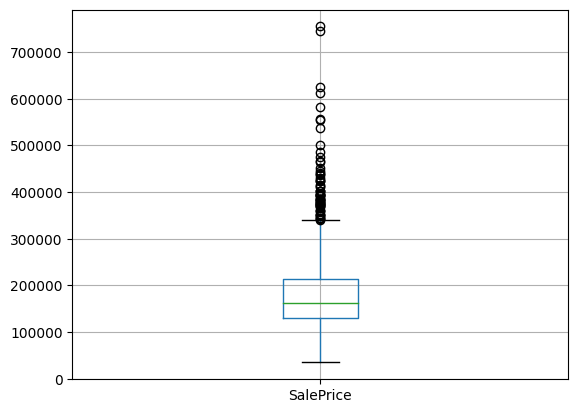

In [ ]:
train_df.select("SalePrice").toPandas().boxplot()

<Axes: xlabel='Id', ylabel='SalePrice'>

<Figure size 1500x1000 with 0 Axes>

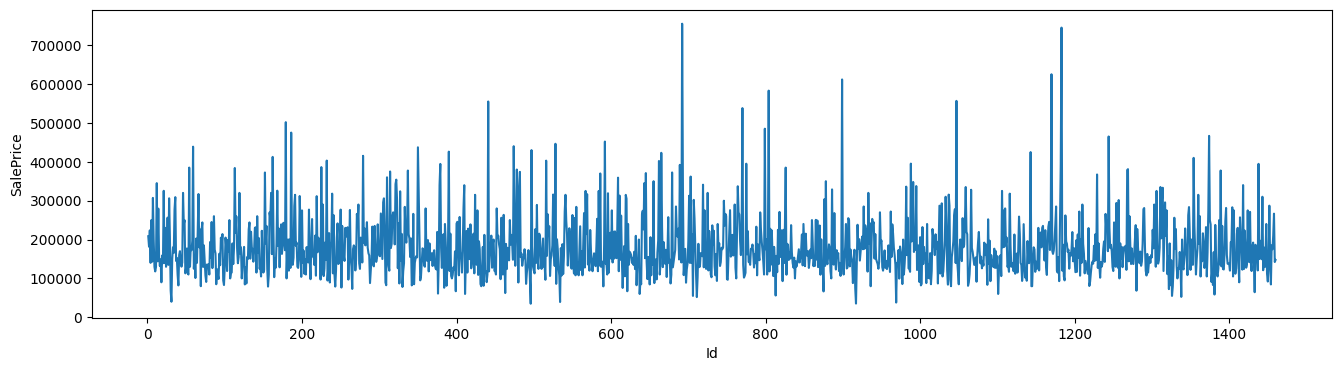

In [ ]:
# Visualization SalePrice
plt.figure(figsize=(15,10))
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=plt.figaspect(0.25))

sale_price = train_df.toPandas()[["SalePrice","Id"]]
sns.lineplot(y="SalePrice",x="Id",data=sale_price, ax=ax)

# **VVVVVVV**

## Rolling Average

In [ ]:
# train_df.toPandas().boxplot(column=['SalePrice'],by=['YrSold'])
avg_YearBuilt = train_df.select(['YearBuilt','SalePrice','OverallQual']).sort(F.asc("YearBuilt"))

avg_YearBuilt=avg_YearBuilt.withColumn("OverallQual",when(F.col("OverallQual")==10, 2).otherwise(F.floor((F.col("OverallQual")-1)/3)))
avg_YearBuilt.groupBy('OverallQual').count().show()
window = Window.orderBy("YearBuilt").partitionBy("OverallQual").rangeBetween(-5, Window.currentRow)
avg1=avg_YearBuilt.withColumn("value_array", F.collect_list(F.col("SalePrice")).over(window))\
    .withColumn("mean", F.expr('AGGREGATE(value_array, DOUBLE(0), (acc, x) -> acc + x, acc -> acc / size(value_array))'))
window2 = Window.orderBy("YearBuilt").rangeBetween(-5, Window.currentRow)
avg2=avg_YearBuilt.withColumn("value_array", F.collect_list(F.col("SalePrice")).over(window2))\
    .withColumn("mean", F.expr('AGGREGATE(value_array, DOUBLE(0), (acc, x) -> acc + x, acc -> acc / size(value_array))'))
# sns.lineplot(y="SalePrice",x="YearBuilt",data=avg_YrSold)


+-----------+-----+
|OverallQual|count|
+-----------+-----+
|          0|   25|
|          1|  887|
|          2|  548|
+-----------+-----+



In [ ]:
mv0=avg1.filter(F.col("OverallQual")==0).select(["YearBuilt","mean"]).toPandas()
mv1=avg1.filter(F.col("OverallQual")==1).select(["YearBuilt","mean"]).toPandas()
mv2=avg1.filter(F.col("OverallQual")==2).select(["YearBuilt","mean"]).toPandas()
mv3=avg2.select(["YearBuilt","mean"]).toPandas()
# mv4=avg_YearBuilt.filter(F.col("OverallQual")==5).select(["YearBuilt","mean"]).toPandas()


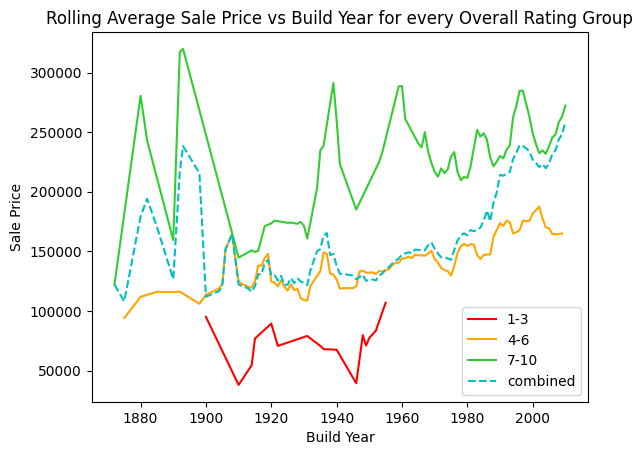

In [ ]:
fig, ax = plt.subplots()
plt.title('Rolling Average Sale Price vs Build Year for every Overall Rating Group')
poor,=ax.plot('YearBuilt',"mean",data=mv0,color='r',label='1-3')
mid,=ax.plot('YearBuilt',"mean",data=mv1,color='#ffa500',label='4-6')
gd,=ax.plot('YearBuilt',"mean",data=mv2,color='#32cd32',label='7-10')
ttl,=ax.plot('YearBuilt',"mean",data=mv3,color='c',ls='--',label='combined')
# plt.plot('YearBuilt',"mean",data=mv4,color='#7cfc00',label='9-10')
ax.legend(handles=[poor, mid,gd,ttl])
plt.xlabel("Build Year")
plt.ylabel("Sale Price")
plt.show()

In [ ]:
# train_df.toPandas().boxplot(column=['SalePrice'],by=['YrSold'])
avg_remodel = train_df.select(['YearRemodAdd','SalePrice','OverallQual']).sort(F.asc("YearRemodAdd"))

avg_remodel=avg_remodel.withColumn("OverallQual",when(F.col("OverallQual")==10, 2).otherwise(F.floor((F.col("OverallQual")-1)/3)))
avg_remodel.groupBy('OverallQual').count().show()
window = Window.orderBy("YearRemodAdd").partitionBy("OverallQual").rangeBetween(-5, Window.currentRow)
avg1=avg_remodel.withColumn("value_array", F.collect_list(F.col("SalePrice")).over(window))\
    .withColumn("mean", F.expr('AGGREGATE(value_array, DOUBLE(0), (acc, x) -> acc + x, acc -> acc / size(value_array))'))
window2 = Window.orderBy("YearRemodAdd").rangeBetween(-5, Window.currentRow)
avg2=avg_remodel.withColumn("value_array", F.collect_list(F.col("SalePrice")).over(window2))\
    .withColumn("mean", F.expr('AGGREGATE(value_array, DOUBLE(0), (acc, x) -> acc + x, acc -> acc / size(value_array))'))
# sns.lineplot(y="SalePrice",x="YearBuilt",data=avg_YrSold)


+-----------+-----+
|OverallQual|count|
+-----------+-----+
|          0|   25|
|          1|  887|
|          2|  548|
+-----------+-----+



In [ ]:
mv0=avg1.filter(F.col("OverallQual")==0).select(["YearRemodAdd","mean"]).toPandas()
mv1=avg1.filter(F.col("OverallQual")==1).select(["YearRemodAdd","mean"]).toPandas()
mv2=avg1.filter(F.col("OverallQual")==2).select(["YearRemodAdd","mean"]).toPandas()
mv3=avg2.select(["YearRemodAdd","mean"]).toPandas()
# mv4=avg_YearBuilt.filter(F.col("OverallQual")==5).select(["YearBuilt","mean"]).toPandas()


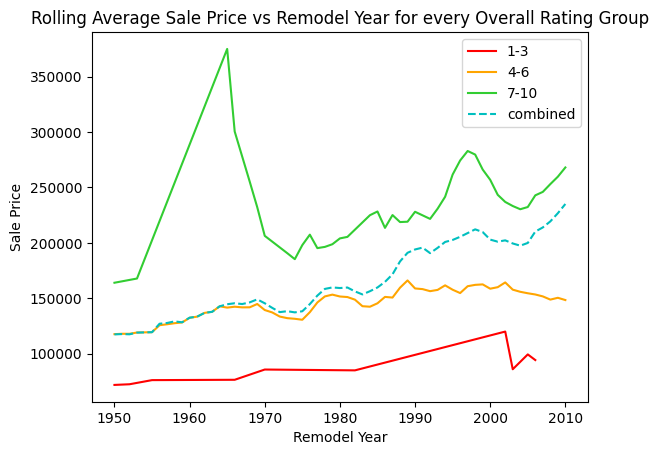

In [ ]:
fig, ax = plt.subplots()
plt.title('Rolling Average Sale Price vs Remodel Year for every Overall Rating Group')
poor,=ax.plot('YearRemodAdd',"mean",data=mv0,color='r',label='1-3')
mid,=ax.plot('YearRemodAdd',"mean",data=mv1,color='#ffa500',label='4-6')
gd,=ax.plot('YearRemodAdd',"mean",data=mv2,color='#32cd32',label='7-10')
ttl,=ax.plot('YearRemodAdd',"mean",data=mv3,color='c',ls='--',label='combined')
# plt.plot('YearBuilt',"mean",data=mv4,color='#7cfc00',label='9-10')
ax.legend(handles=[poor, mid,gd,ttl])
plt.xlabel("Remodel Year")
plt.ylabel("Sale Price")
plt.show()

In [ ]:
def corr_ratio(df,cat_feat,target):
    mean=df.select(avg(col(target))).first()[0]
    d=df.agg(F.sum((df.SalePrice-mean)**2)).first()[0]
    r={}
    for feat in cat_feat:
        a=df.groupBy(feat).count().join(df.groupBy(feat).avg(target),feat)
        result=a.agg(F.sum(col('count')*(col(f'avg({target})')-mean)**2)).first()[0]
        r[feat]=(result/d)**0.5
    # print(r)
    return r
cat_corr=corr_ratio(train_df,cat_feat,'SalePrice')


<Axes: >

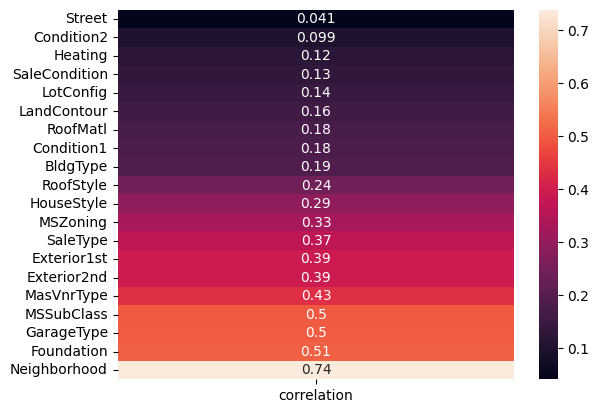

In [ ]:
# [i,v for i,v in cat_corr.items()]
sns.heatmap(pd.DataFrame([v for i,v in cat_corr.items()]
,index=cat_feat,columns=['correlation']).sort_values(by=["correlation"]),annot=True)

In [ ]:
num_corr=pd.DataFrame(train_df.select(numerical_feat).toPandas().corr(),columns=["SalePrice"]).sort_values(by='SalePrice')

<Axes: >

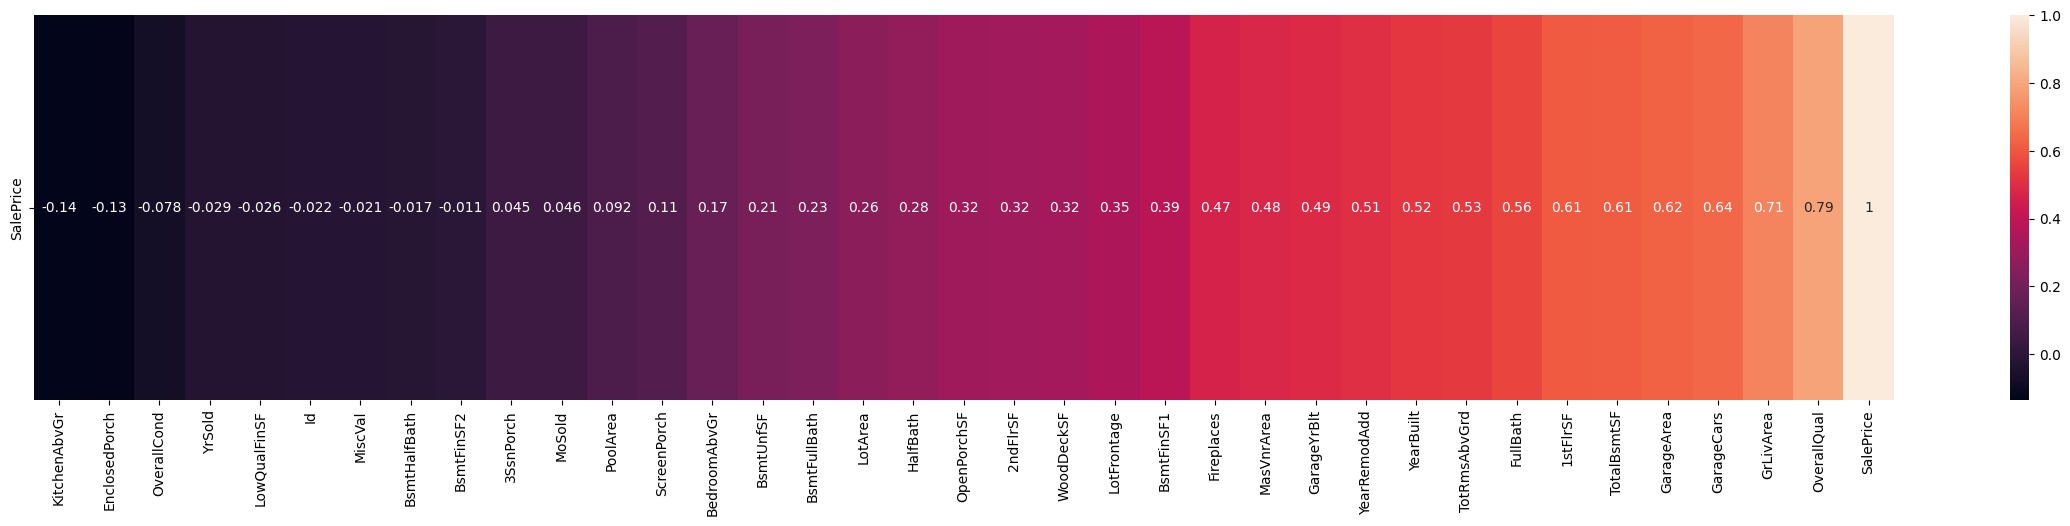

In [ ]:
plt.figure(figsize=(30,5))
sns.heatmap(num_corr.T,annot=True)

In [ ]:
cat_corr_qual=corr_ratio(train_df,cat_feat,'OverallQual')


<Axes: >

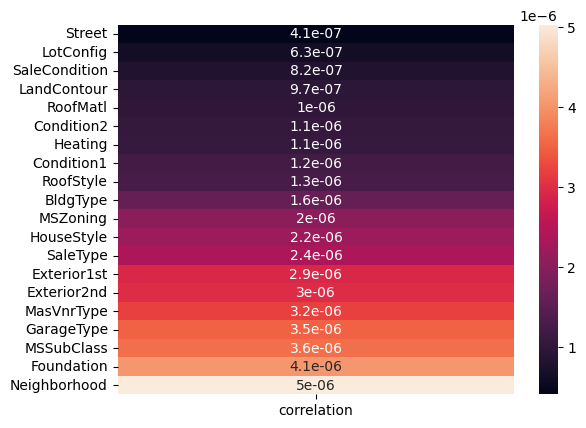

In [ ]:
sns.heatmap(pd.DataFrame([v for i,v in cat_corr_qual.items()]
,index=cat_feat,columns=['correlation']).sort_values(by=["correlation"]),annot=True)

<Axes: >

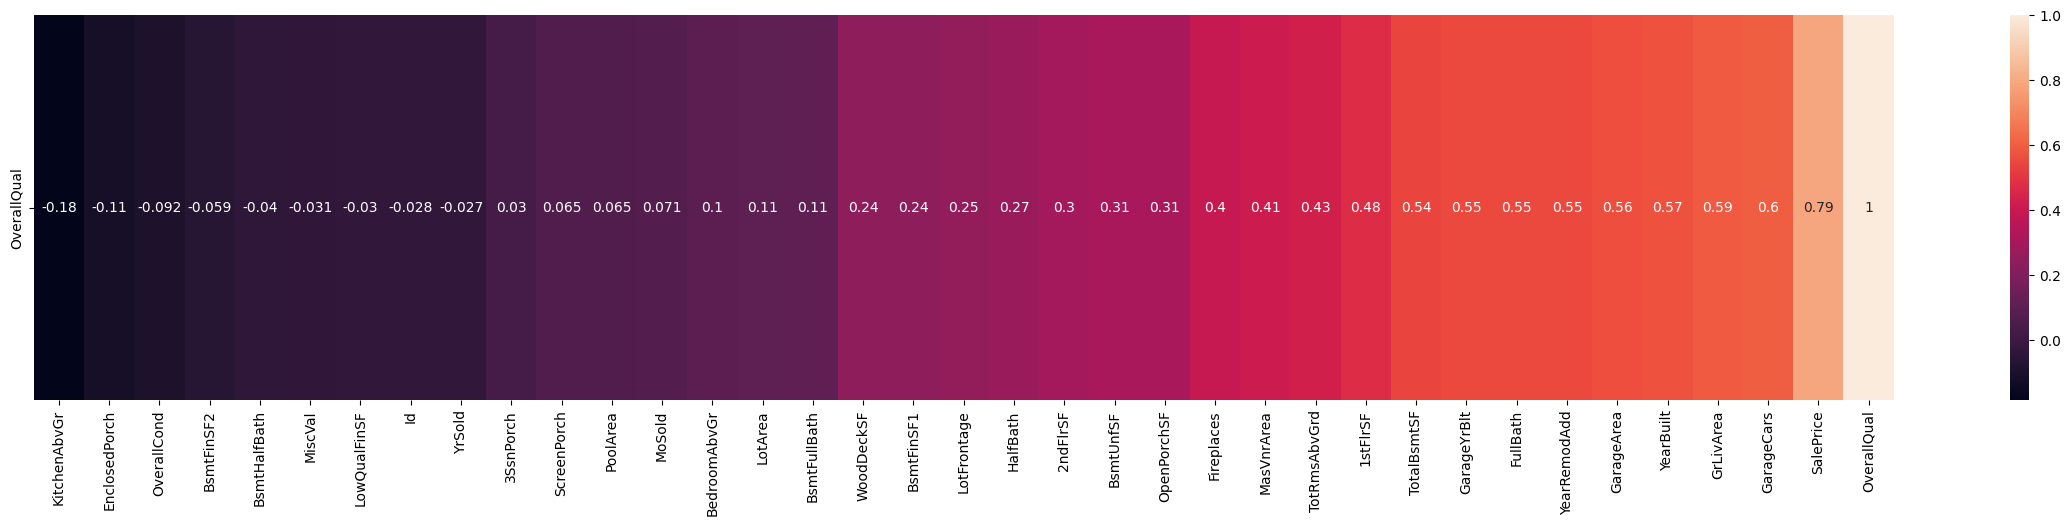

In [ ]:
num_corr_qual=pd.DataFrame(train_df.select(numerical_feat).toPandas().corr(),columns=["OverallQual"]).sort_values(by='OverallQual')
plt.figure(figsize=(30,5))
sns.heatmap(num_corr_qual.T,annot=True)

In [ ]:
set(list(num_corr_qual.index.values)[-15:-2]).symmetric_difference(list(num_corr.index.values)[-15:-2])

{'BsmtFinSF1', 'OpenPorchSF'}

# **^^^^^**

In [ ]:
train_df.filter(train_df.YearBuilt.isin([1880,1892,1893])).toPandas()[['YearBuilt','YearRemodAdd','SalePrice']].sort_values('SalePrice')

,YearBuilt,YearRemodAdd,SalePrice
6,1892,1965,107500
5,1880,1950,117500
3,1880,1991,124000
4,1880,2003,265979
1,1880,2002,295000
2,1893,2000,325000
0,1892,1993,475000


In [ ]:
# Add bulit_remod column and append new data(between built and remodeling)
train_df = train_df.withColumn('Built_Remod', train_df.YearRemodAdd - train_df.YearBuilt)
train_df.toPandas()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Built_Remod
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,0.0,208500,0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,0.0,181500,0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,0.0,223500,1
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,1.0,140000,55
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,0.0,250000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,8,2007,WD,0.0,175000,1
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,NaN,MnPrv,NaN,0,2,2010,WD,0.0,210000,10
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,NaN,GdPrv,Shed,2500,5,2010,WD,0.0,266500,65
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,4,2010,WD,0.0,142125,46


In [ ]:
# Checking the number of years passed before remodeling after the house has been built
train_df.groupBy("Built_Remod").count().orderBy("Built_Remod").toPandas()

,Built_Remod,count
0,0,764
1,1,215
2,2,14
3,3,4
4,4,4
...,...,...
104,111,1
105,115,1
106,121,1
107,122,1


<Axes: xlabel='Built_Remod', ylabel='count'>

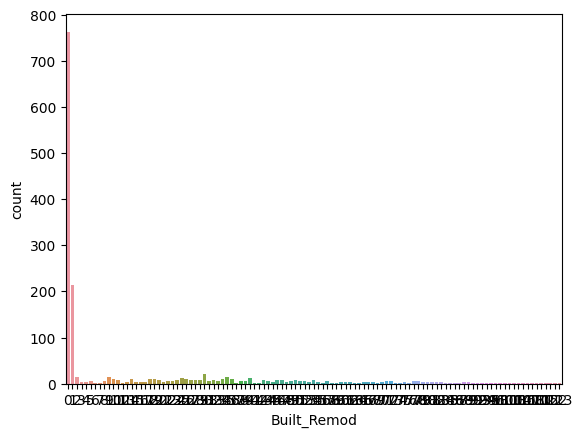

In [ ]:
train_df_remodeling_info = train_df.groupBy("Built_Remod").count().orderBy("Built_Remod").toPandas()
sns.barplot(x="Built_Remod",y="count" ,data=train_df_remodeling_info)

Many houses are not remodelled.
Two feature engineering are required
- Addition of the variable whether the house has been remodeled
- Removal of the variable YearRemod

<Axes: xlabel='Built_Remod', ylabel='SalePrice'>

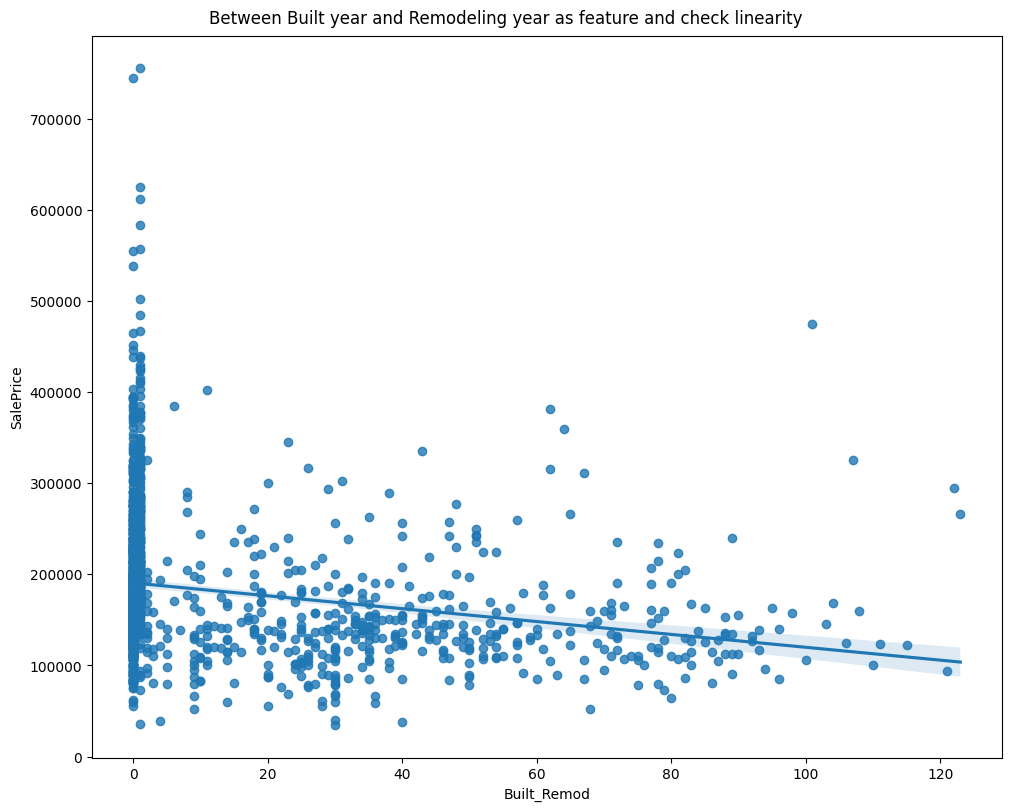

In [ ]:
# Check Built_Remod Feature
fig,ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(10,8))
fig.suptitle("Between Built year and Remodeling year as feature and check linearity")
bdf=train_df.toPandas()
# bdf=bdf.loc[bdf["Built_Remod"]!=0]

sns.regplot(x="Built_Remod", y="SalePrice", data=train_df.toPandas(), ax=ax)

In [ ]:
bdf["Built_Remod"].value_counts()

0      764
1      215
30      21
9       14
2       14
      ... 
100      1
76       1
110      1
122      1
84       1
Name: Built_Remod, Length: 109, dtype: int64

It does not seem to affect SalePrice of the house directly.

In [ ]:
train_df.filter(train_df.YearBuilt.isin([1880,1892,1893])).toPandas()[['Built_Remod','SalePrice']].sort_values('SalePrice')

,Built_Remod,SalePrice
6,73,107500
5,70,117500
3,111,124000
4,123,265979
1,122,295000
2,107,325000
0,101,475000


In [ ]:
train_df.toPandas()[['Built_Remod','SalePrice']].sort_values('SalePrice')

,Built_Remod,SalePrice
495,30,34900
916,1,35311
968,40,37900
533,4,39300
30,30,40000
...,...,...
803,1,582933
898,1,611657
1169,1,625000
1182,0,745000


<Axes: xlabel='Built_Remod', ylabel='SalePrice'>

<Figure size 1500x1000 with 0 Axes>

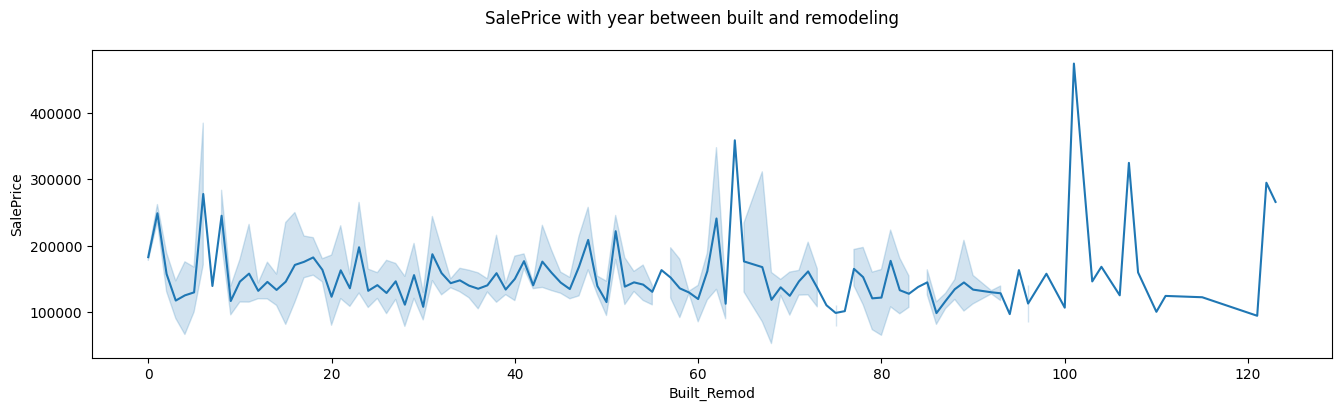

In [ ]:
# SalePrice with year between built and remodeling
plt.figure(figsize=(15,10))
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=plt.figaspect(0.25))
fig.suptitle("SalePrice with year between built and remodeling")

sale_price_byBuiltRemod = train_df.toPandas()[['Built_Remod','SalePrice']].sort_values('SalePrice')
sns.lineplot(y="SalePrice",x="Built_Remod",data=sale_price_byBuiltRemod, ax=ax)

There is a clear observation that when the year of remodeling is more than 60 years after the year of construction, the SalePrice increase a lot. Based on this, it can be estimated that the SalePrice will increase a lot when the old houses are remodeled.

In [ ]:
# Some abnormal values are removed
cond = (col('YearBuilt') <= 1900) & (col('SalePrice') > 200000)

print("After remove abnormal")
print(train_df.filter(~cond).count())
train_df.filter(~cond).toPandas()

After remove abnormal
1456


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Built_Remod
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,0.0,208500,0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,0.0,181500,0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,0.0,223500,1
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,1.0,140000,55
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,0.0,250000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,8,2007,WD,0.0,175000,1
1452,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,NaN,MnPrv,NaN,0,2,2010,WD,0.0,210000,10
1453,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,NaN,GdPrv,Shed,2500,5,2010,WD,0.0,266500,65
1454,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,4,2010,WD,0.0,142125,46


In [ ]:
train_df_preprocess = train_df.filter(~cond)

<Axes: xlabel='YearBuilt', ylabel='avg(SalePrice)'>

<Figure size 1800x1200 with 0 Axes>

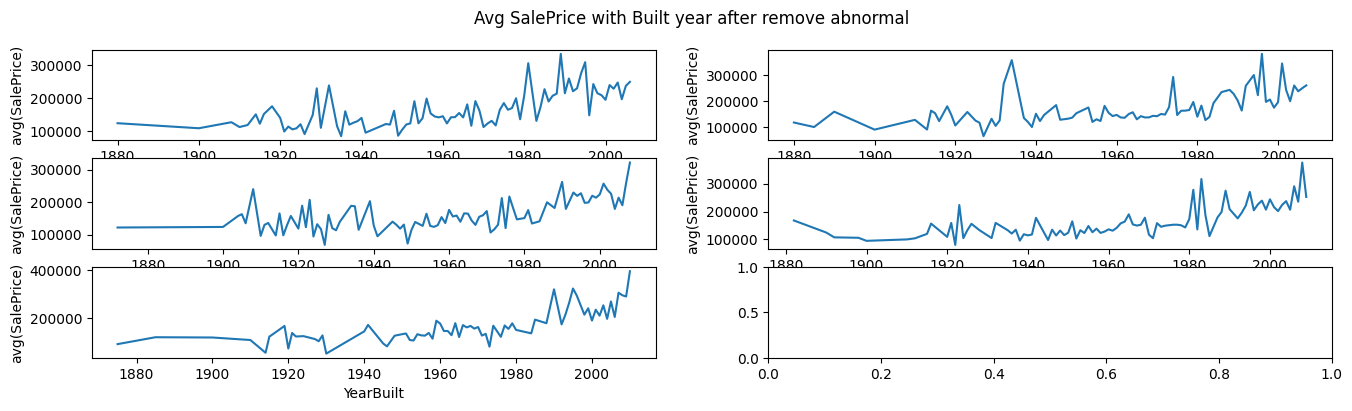

In [ ]:
# Avg SalePrice by Built Year after remove abnormal
plt.figure(figsize=(18,12))
fig,ax = plt.subplots(nrows=3,ncols=2,figsize=plt.figaspect(0.25))
fig.suptitle("Avg SalePrice with Built year after remove abnormal")

sale_price_byYear = train_df_preprocess.filter(train_df_preprocess.YrSold == 2006).groupby("YearBuilt").agg(mean("SalePrice")).toPandas()
sns.lineplot(y="avg(SalePrice)",x="YearBuilt",data=sale_price_byYear, ax=ax[0][0])

sale_price_byYear = train_df_preprocess.filter(train_df_preprocess.YrSold == 2007).groupby("YearBuilt").agg(mean("SalePrice")).toPandas()
sns.lineplot(y="avg(SalePrice)",x="YearBuilt",data=sale_price_byYear, ax=ax[0][1])

sale_price_byYear = train_df_preprocess.filter(train_df_preprocess.YrSold == 2008).groupby("YearBuilt").agg(mean("SalePrice")).toPandas()
sns.lineplot(y="avg(SalePrice)",x="YearBuilt",data=sale_price_byYear, ax=ax[1][0])

sale_price_byYear = train_df_preprocess.filter(train_df_preprocess.YrSold == 2009).groupby("YearBuilt").agg(mean("SalePrice")).toPandas()
sns.lineplot(y="avg(SalePrice)",x="YearBuilt",data=sale_price_byYear, ax=ax[1][1])

sale_price_byYear = train_df_preprocess.filter(train_df_preprocess.YrSold == 2010).groupby("YearBuilt").agg(mean("SalePrice")).toPandas()
sns.lineplot(y="avg(SalePrice)",x="YearBuilt",data=sale_price_byYear, ax=ax[2][0])

<Axes: xlabel='YearBuilt', ylabel='avg(SalePrice)'>

<Figure size 1500x1000 with 0 Axes>

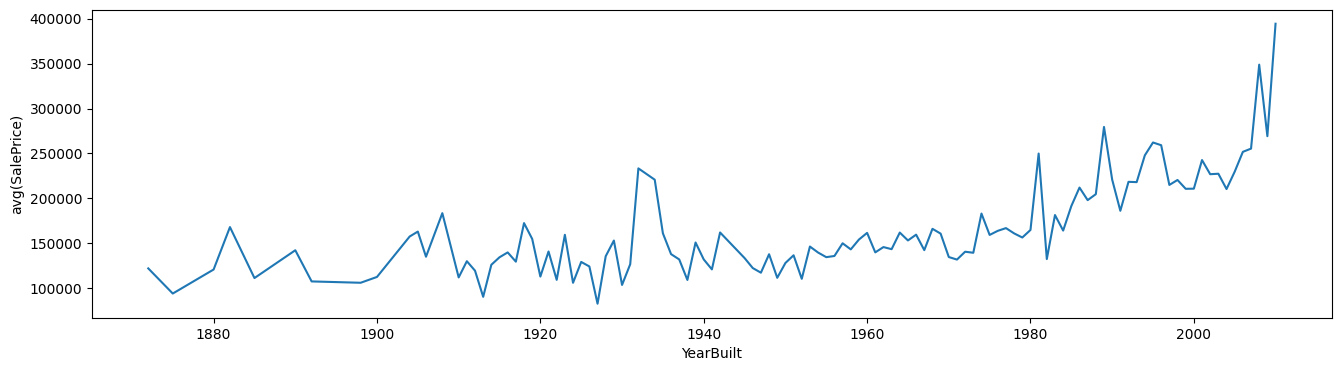

In [ ]:
plt.figure(figsize=(15,10))
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=plt.figaspect(0.25))

sale_price_byYear = train_df_preprocess.groupby("YearBuilt").agg(mean("SalePrice")).toPandas()
sns.lineplot(y="avg(SalePrice)",x="YearBuilt",data=sale_price_byYear, ax=ax)

The new houses seem to have larger SalePrice

<Axes: xlabel='YrSold', ylabel='avg(SalePrice)'>

<Figure size 1500x1000 with 0 Axes>

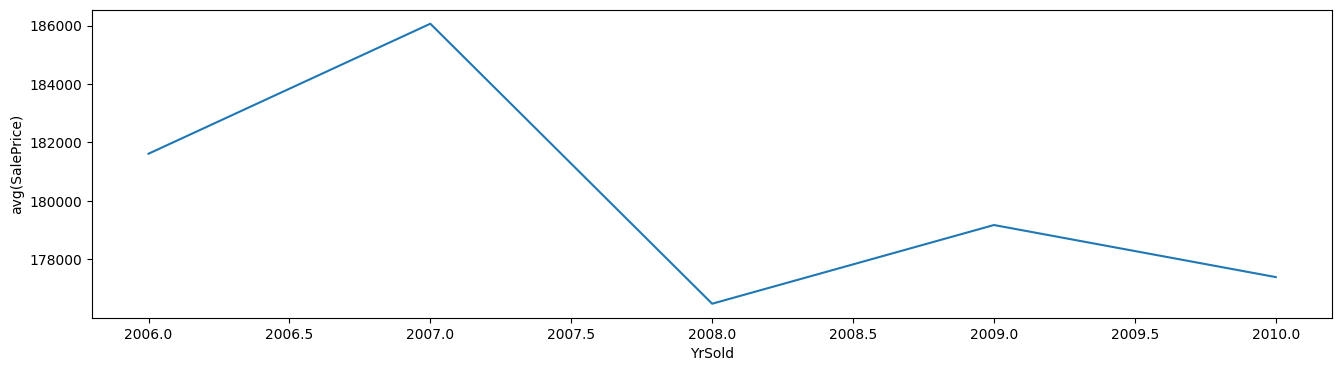

In [ ]:
# Mean SalePrice by Year
plt.figure(figsize=(15,10))
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=plt.figaspect(0.25))

sale_price_byYear = train_df_preprocess.groupby("YrSold").agg(mean("SalePrice")).toPandas()
sns.lineplot(y="avg(SalePrice)",x="YrSold",data=sale_price_byYear, ax=ax)

It is estimated that some high price houses are sold in particular years

Text(0.5, 1.0, 'Min SalePrice by Year')

<Figure size 1500x1000 with 0 Axes>

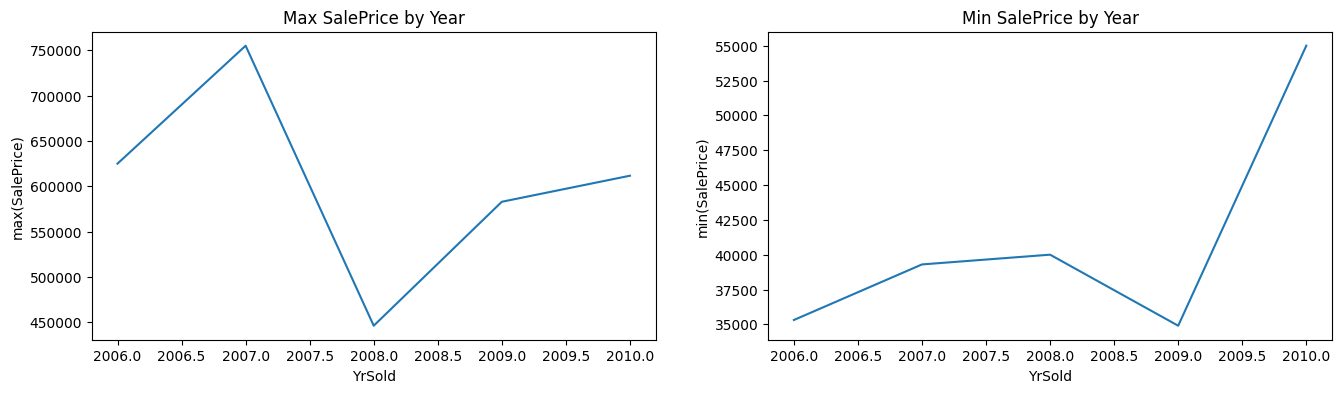

In [ ]:
plt.figure(figsize=(15,10))
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=plt.figaspect(0.25))

# Max SalePrice by Year
sale_price_byYear = train_df_preprocess.groupby("YrSold").agg(max("SalePrice")).toPandas()
sns.lineplot(y="max(SalePrice)",x="YrSold",data=sale_price_byYear, ax=ax[0])
ax[0].set_title("Max SalePrice by Year")

# Min SalePrice by Year
sale_price_byYear = train_df_preprocess.groupby("YrSold").agg(min("SalePrice")).toPandas()
sns.lineplot(y="min(SalePrice)",x="YrSold",data=sale_price_byYear, ax=ax[1])
ax[1].set_title("Min SalePrice by Year")

Max SalePrice seem to have large impact

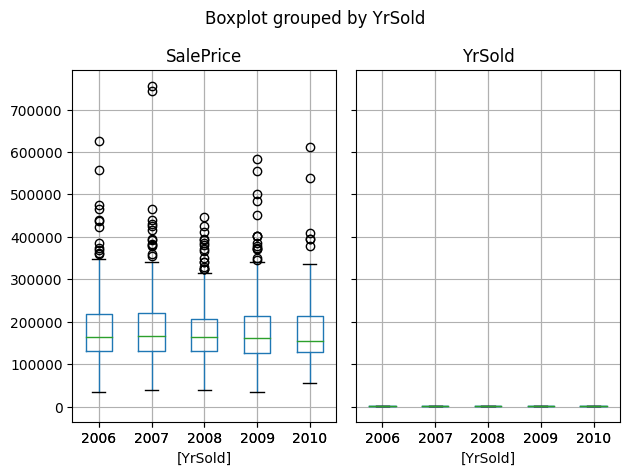

In [ ]:
train_df.toPandas().boxplot(column=['SalePrice', 'YrSold'],by=['YrSold'])
plt.tight_layout()

There are some houses with exceptionally high SalePrice.

---



**Normal Price House VS High Price House**

In [ ]:
Q3 = train_df.select("SalePrice").toPandas().quantile(.75)
Q1 = train_df.select("SalePrice").toPandas().quantile(.25)
IQR = Q3 - Q1

In [ ]:
# divide outlier data and normal data
# compare A group(high price house) vs B group(normal price house)
train_pd = train_df.toPandas()
outlier_condition = Q3 + (1.5*IQR)
high_value_house = train_pd[train_pd["SalePrice"] > outlier_condition[0]]
normal_value_house = train_pd[train_pd["SalePrice"] <= outlier_condition[0]]

In [ ]:
high_value_house.dropna(inplace=True)
normal_value_house.dropna(inplace=True)

In [ ]:
high_value_house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Built_Remod
53,54,20,RL,68.0,50271,Pave,NaN,IR1,Low,AllPub,...,NaN,NaN,NaN,0,11,2006,WD,0.0,385000,6
161,162,60,RL,110.0,13688,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,3,2008,WD,0.0,412500,1
185,186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,...,NaN,GdPrv,NaN,0,6,2006,WD,0.0,475000,101
224,225,20,RL,103.0,13472,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,6,2009,WD,0.0,386250,0
231,232,60,RL,174.0,15138,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,7,2009,WD,0.0,403000,1


In [ ]:
normal_value_house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Built_Remod
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,0.0,208500,0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,0.0,181500,0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,0.0,223500,1
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,1.0,140000,55
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,0.0,250000,0


In [ ]:
# Group compare (A vs B)
# 'OverallCond' feature has no any different
print("High Price")
print(high_value_house[high_value_house["LotFrontage"]!="NA"][['LotFrontage','LotArea','OverallQual','LowQualFinSF','TotRmsAbvGrd','Fireplaces','GarageArea',
                                                       'WoodDeckSF','ScreenPorch','SalePrice']].astype(int).describe())

print("-"*70)

print("Normal Price")
print(normal_value_house[normal_value_house["LotFrontage"]!="NA"][['LotFrontage','LotArea','OverallQual','LowQualFinSF','TotRmsAbvGrd','Fireplaces','GarageArea',
                                                       'WoodDeckSF','ScreenPorch','SalePrice']].astype(int).describe())

High Price
       LotFrontage        LotArea  OverallQual  LowQualFinSF  TotRmsAbvGrd  \
count    26.000000      26.000000    26.000000     26.000000     26.000000   
mean     93.653846   26646.461538     8.807692     22.000000      8.884615   
std      31.936114   40487.760077     0.938903    112.178429      1.657152   
min      42.000000    8834.000000     7.000000      0.000000      5.000000   
25%      74.250000   12587.000000     8.000000      0.000000      8.000000   
50%      90.500000   14008.500000     9.000000      0.000000      9.000000   
75%     104.750000   20057.000000     9.750000      0.000000     10.000000   
max     174.000000  215245.000000    10.000000    572.000000     12.000000   

       Fireplaces  GarageArea  WoodDeckSF  ScreenPorch      SalePrice  
count   26.000000   26.000000    26.00000    26.000000      26.000000  
mean     1.423077  778.115385   253.00000    30.384615  432851.000000  
std      0.643309  113.827001   195.11043    93.187157  116755.694893 

For variable LotArea and WoodDeckSF, they tend to have higher max value and average in high-price houses, which can be regarded as the major variable. For other variables, the average value is higher and the max value is relatively lower.

([<matplotlib.patches.Wedge at 0x7ff4d79c9750>,
 [Text(-0.37350238104303685, 1.0346477523076065, 'nan'),
  Text(-0.868589900560829, 0.6749456160637902, '1.0'),
  Text(0.5878097906170371, -0.9297739779402063, '0.0')],
 [Text(-0.20372857147802007, 0.5643533194405126, '11.0%'),
  Text(-0.47377630939681575, 0.36815215421661285, '6.9%'),
  Text(0.32062352215474743, -0.5071494425128398, '82.1%')])

<Figure size 1500x1000 with 0 Axes>

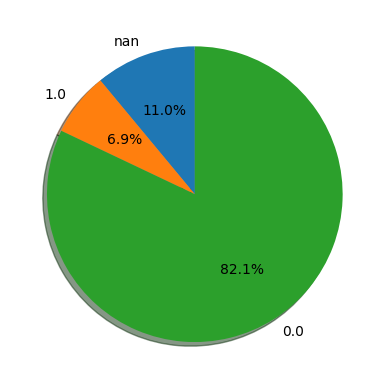

In [ ]:
plt.figure(figsize=(15,10))
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=plt.figaspect(0.45))

sale_condition = train_df.groupby("SaleCondition").count().toPandas()
ax.pie(x="count",labels="SaleCondition",data=sale_condition, autopct='%1.1f%%', shadow=True,startangle=90
    , radius=1)

In [ ]:
print("High price house sale condition")
print(high_value_house.groupby("SaleCondition").count()["SalePrice"])
print("-"*50)
print("low price house sale condition")
print(normal_value_house.groupby("SaleCondition").count()["SalePrice"])

High price house sale condition
SaleCondition
0.0    25
1.0     1
Name: SalePrice, dtype: int64
--------------------------------------------------
low price house sale condition
SaleCondition
0.0    878
1.0     70
Name: SalePrice, dtype: int64


**Total linear relationship**

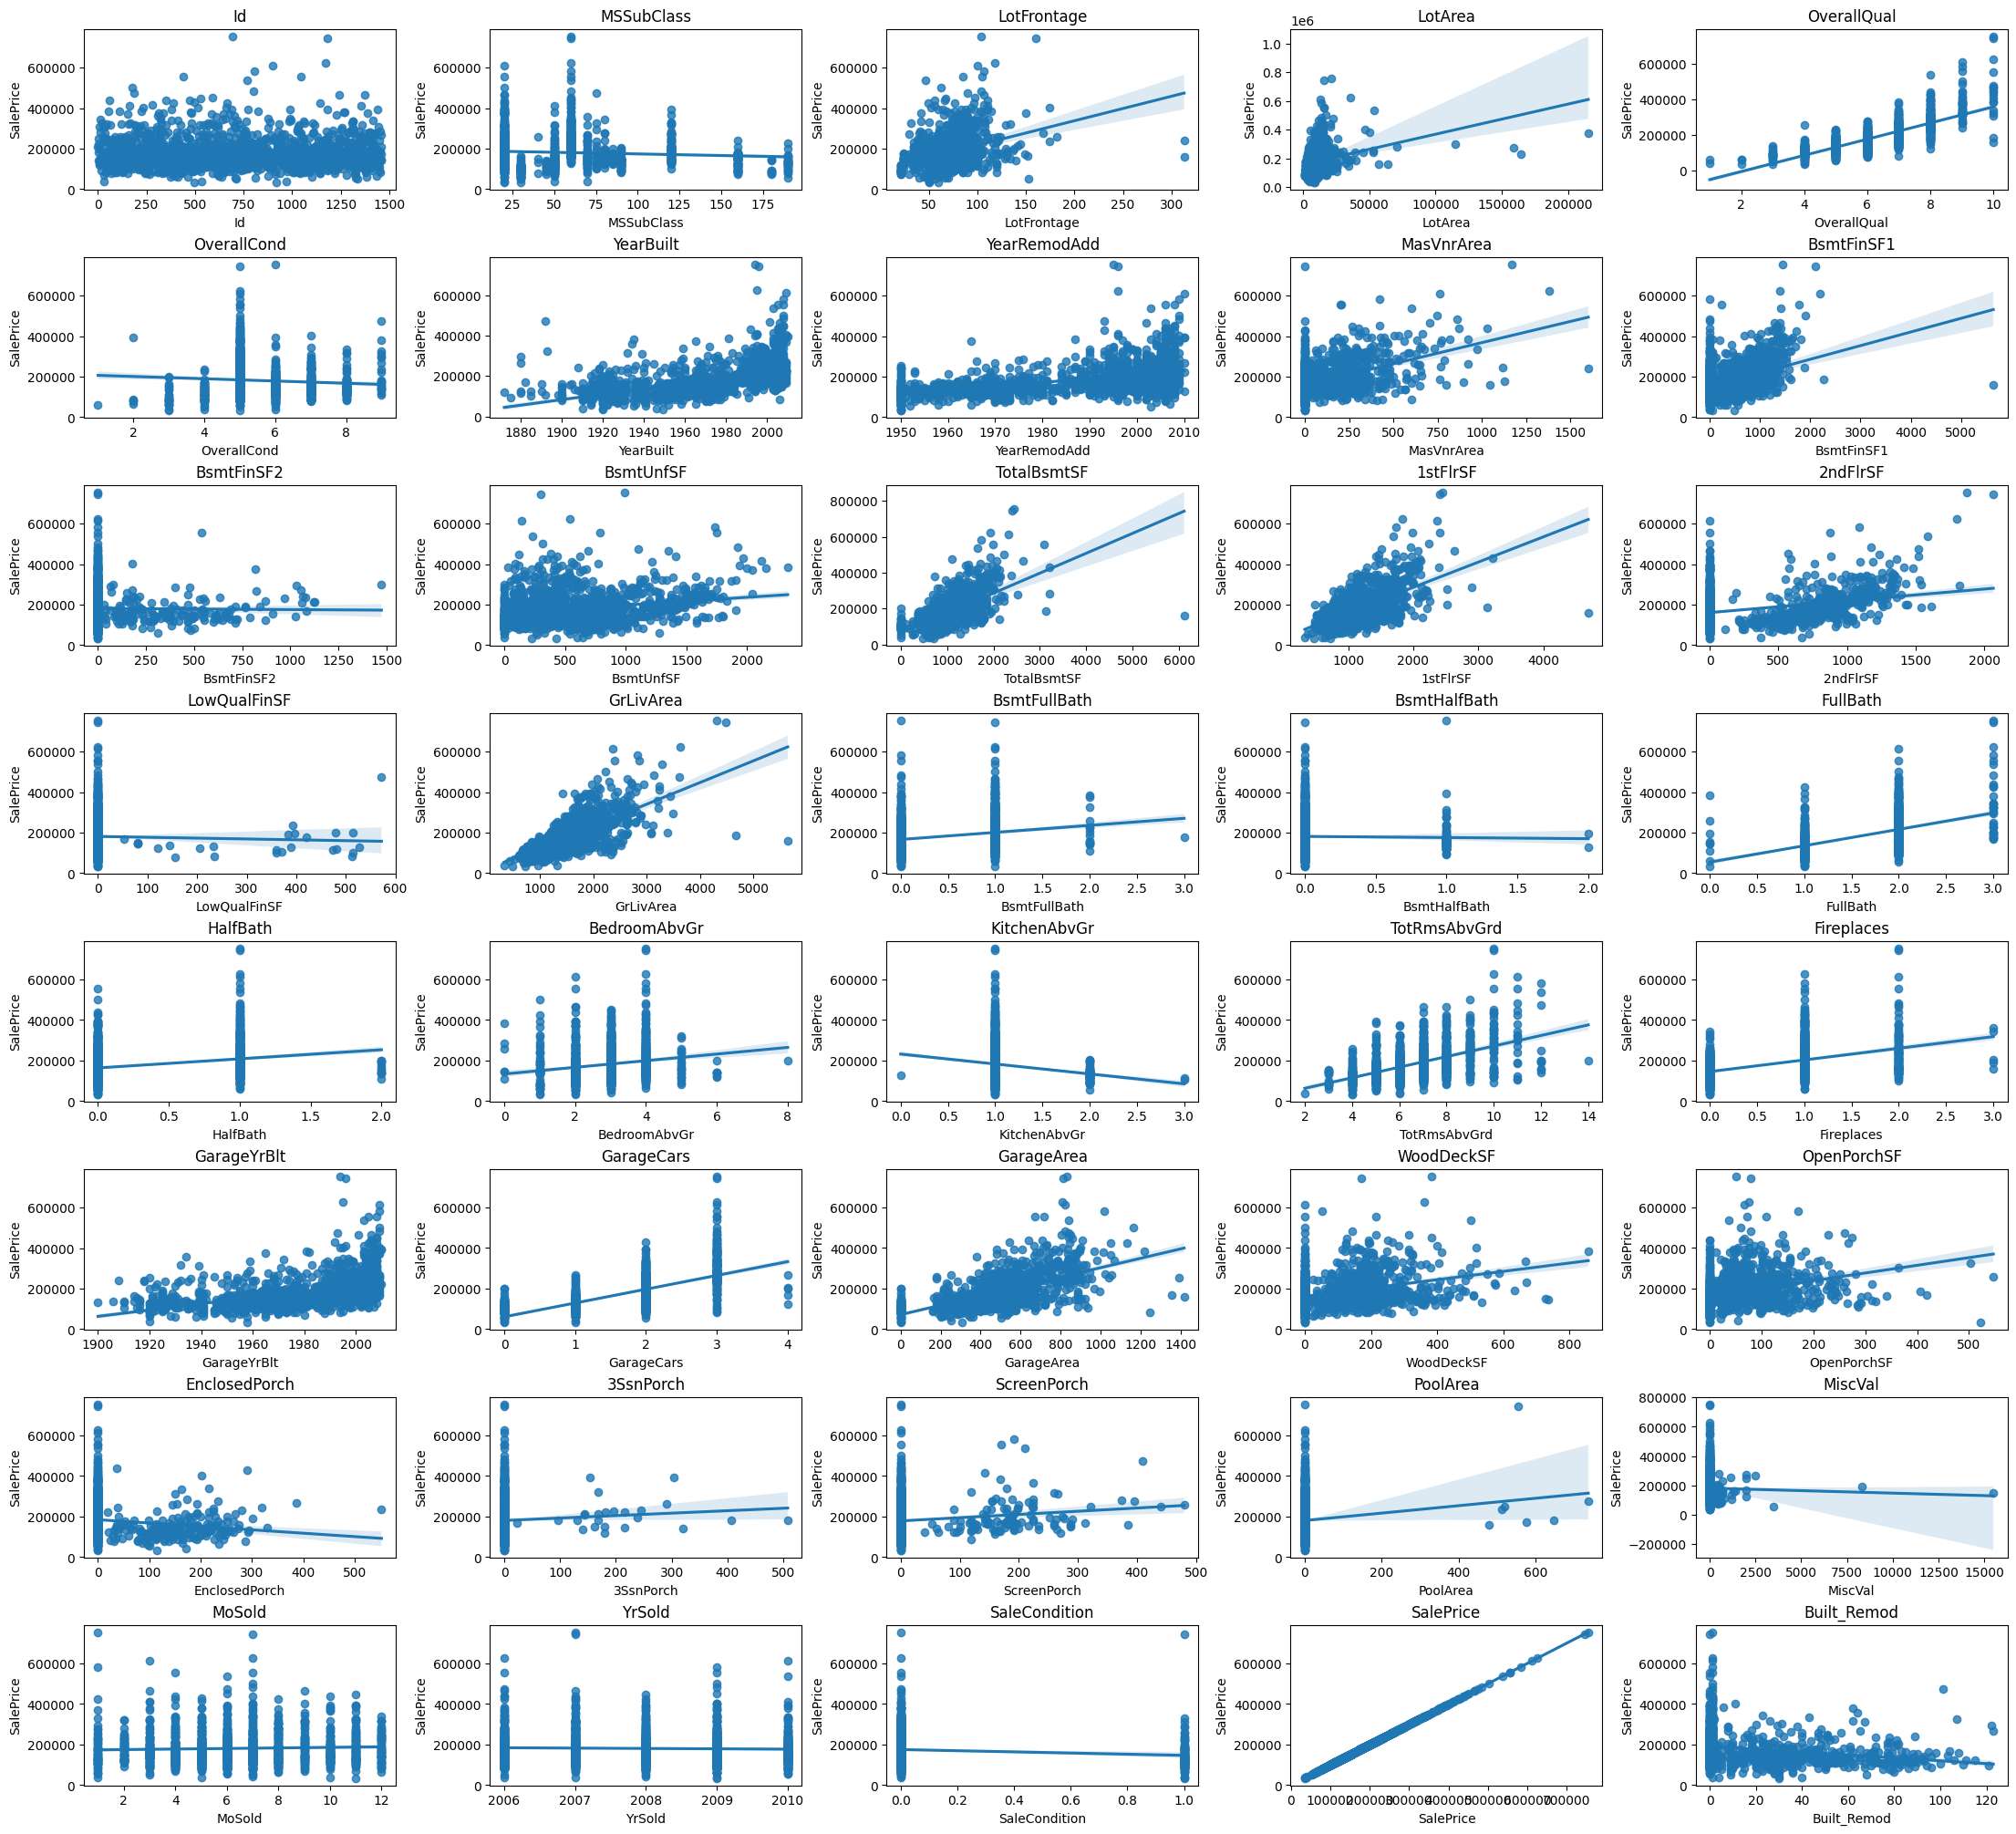

In [ ]:
columnList = train_df.drop(*cols).columns
fig,ax = plt.subplots(nrows=8,ncols=5,figsize=(22,20),constrained_layout=True)
fig.subplots_adjust(hspace=2)

idx, jdx = 0, 0
for arg in columnList:
    sns.regplot(x=arg,y="SalePrice",data=train_df.toPandas(),ax=ax[jdx][idx])
    ax[jdx,idx].set_title(arg)
    if idx == 4:
        jdx += 1
        idx = 0
    else:
        idx +=1

Some variable like LotArea, BsmtFinSF, TotalBsmfF has linear relationship with SalePrice

### Categorical variable Targeting

In [ ]:
print("Pandas Style")
print(train_df.toPandas()["Street"].value_counts())

print("-"*10)

# Analyze Spark DataFrame
print("Spark Style")
print(train_df.groupBy('Street').count().show())

Pandas Style
Pave    1454
Grvl       6
Name: Street, dtype: int64
----------
Spark Style
+------+-----+
|Street|count|
+------+-----+
|  Pave| 1454|
|  Grvl|    6|
+------+-----+

None


In [ ]:
print(train_df.groupBy("HouseStyle").count().show())

+----------+-----+
|HouseStyle|count|
+----------+-----+
|    1.5Fin|  154|
|      SLvl|   65|
|    SFoyer|   37|
|    2.5Fin|    8|
|    2Story|  445|
|    2.5Unf|   11|
|    1Story|  726|
|    1.5Unf|   14|
+----------+-----+

None


In [ ]:
print(train_df.groupBy("SaleType").count().show())

+--------+-----+
|SaleType|count|
+--------+-----+
|   ConLD|    9|
|     COD|   43|
|     Con|    2|
|   ConLI|    5|
|     CWD|    4|
|   ConLw|    5|
|      WD| 1267|
|     New|  122|
|     Oth|    3|
+--------+-----+

None


In [ ]:
train_df.groupBy("SaleType").count().toPandas()

,SaleType,count
0,ConLD,9
1,COD,43
2,Con,2
3,ConLI,5
4,CWD,4
5,ConLw,5
6,WD,1267
7,New,122
8,Oth,3


<Axes: xlabel='SaleType', ylabel='count'>

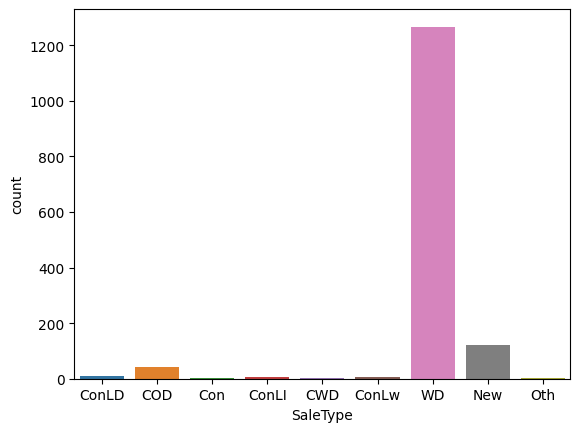

In [ ]:
categorical_df = train_df.groupBy("SaleType").count().toPandas()
sns.barplot(x="SaleType",y="count",data=categorical_df)

In [ ]:
columnList = [item[0] for item in train_df.dtypes if item[1].startswith('string')]
len(columnList)

42

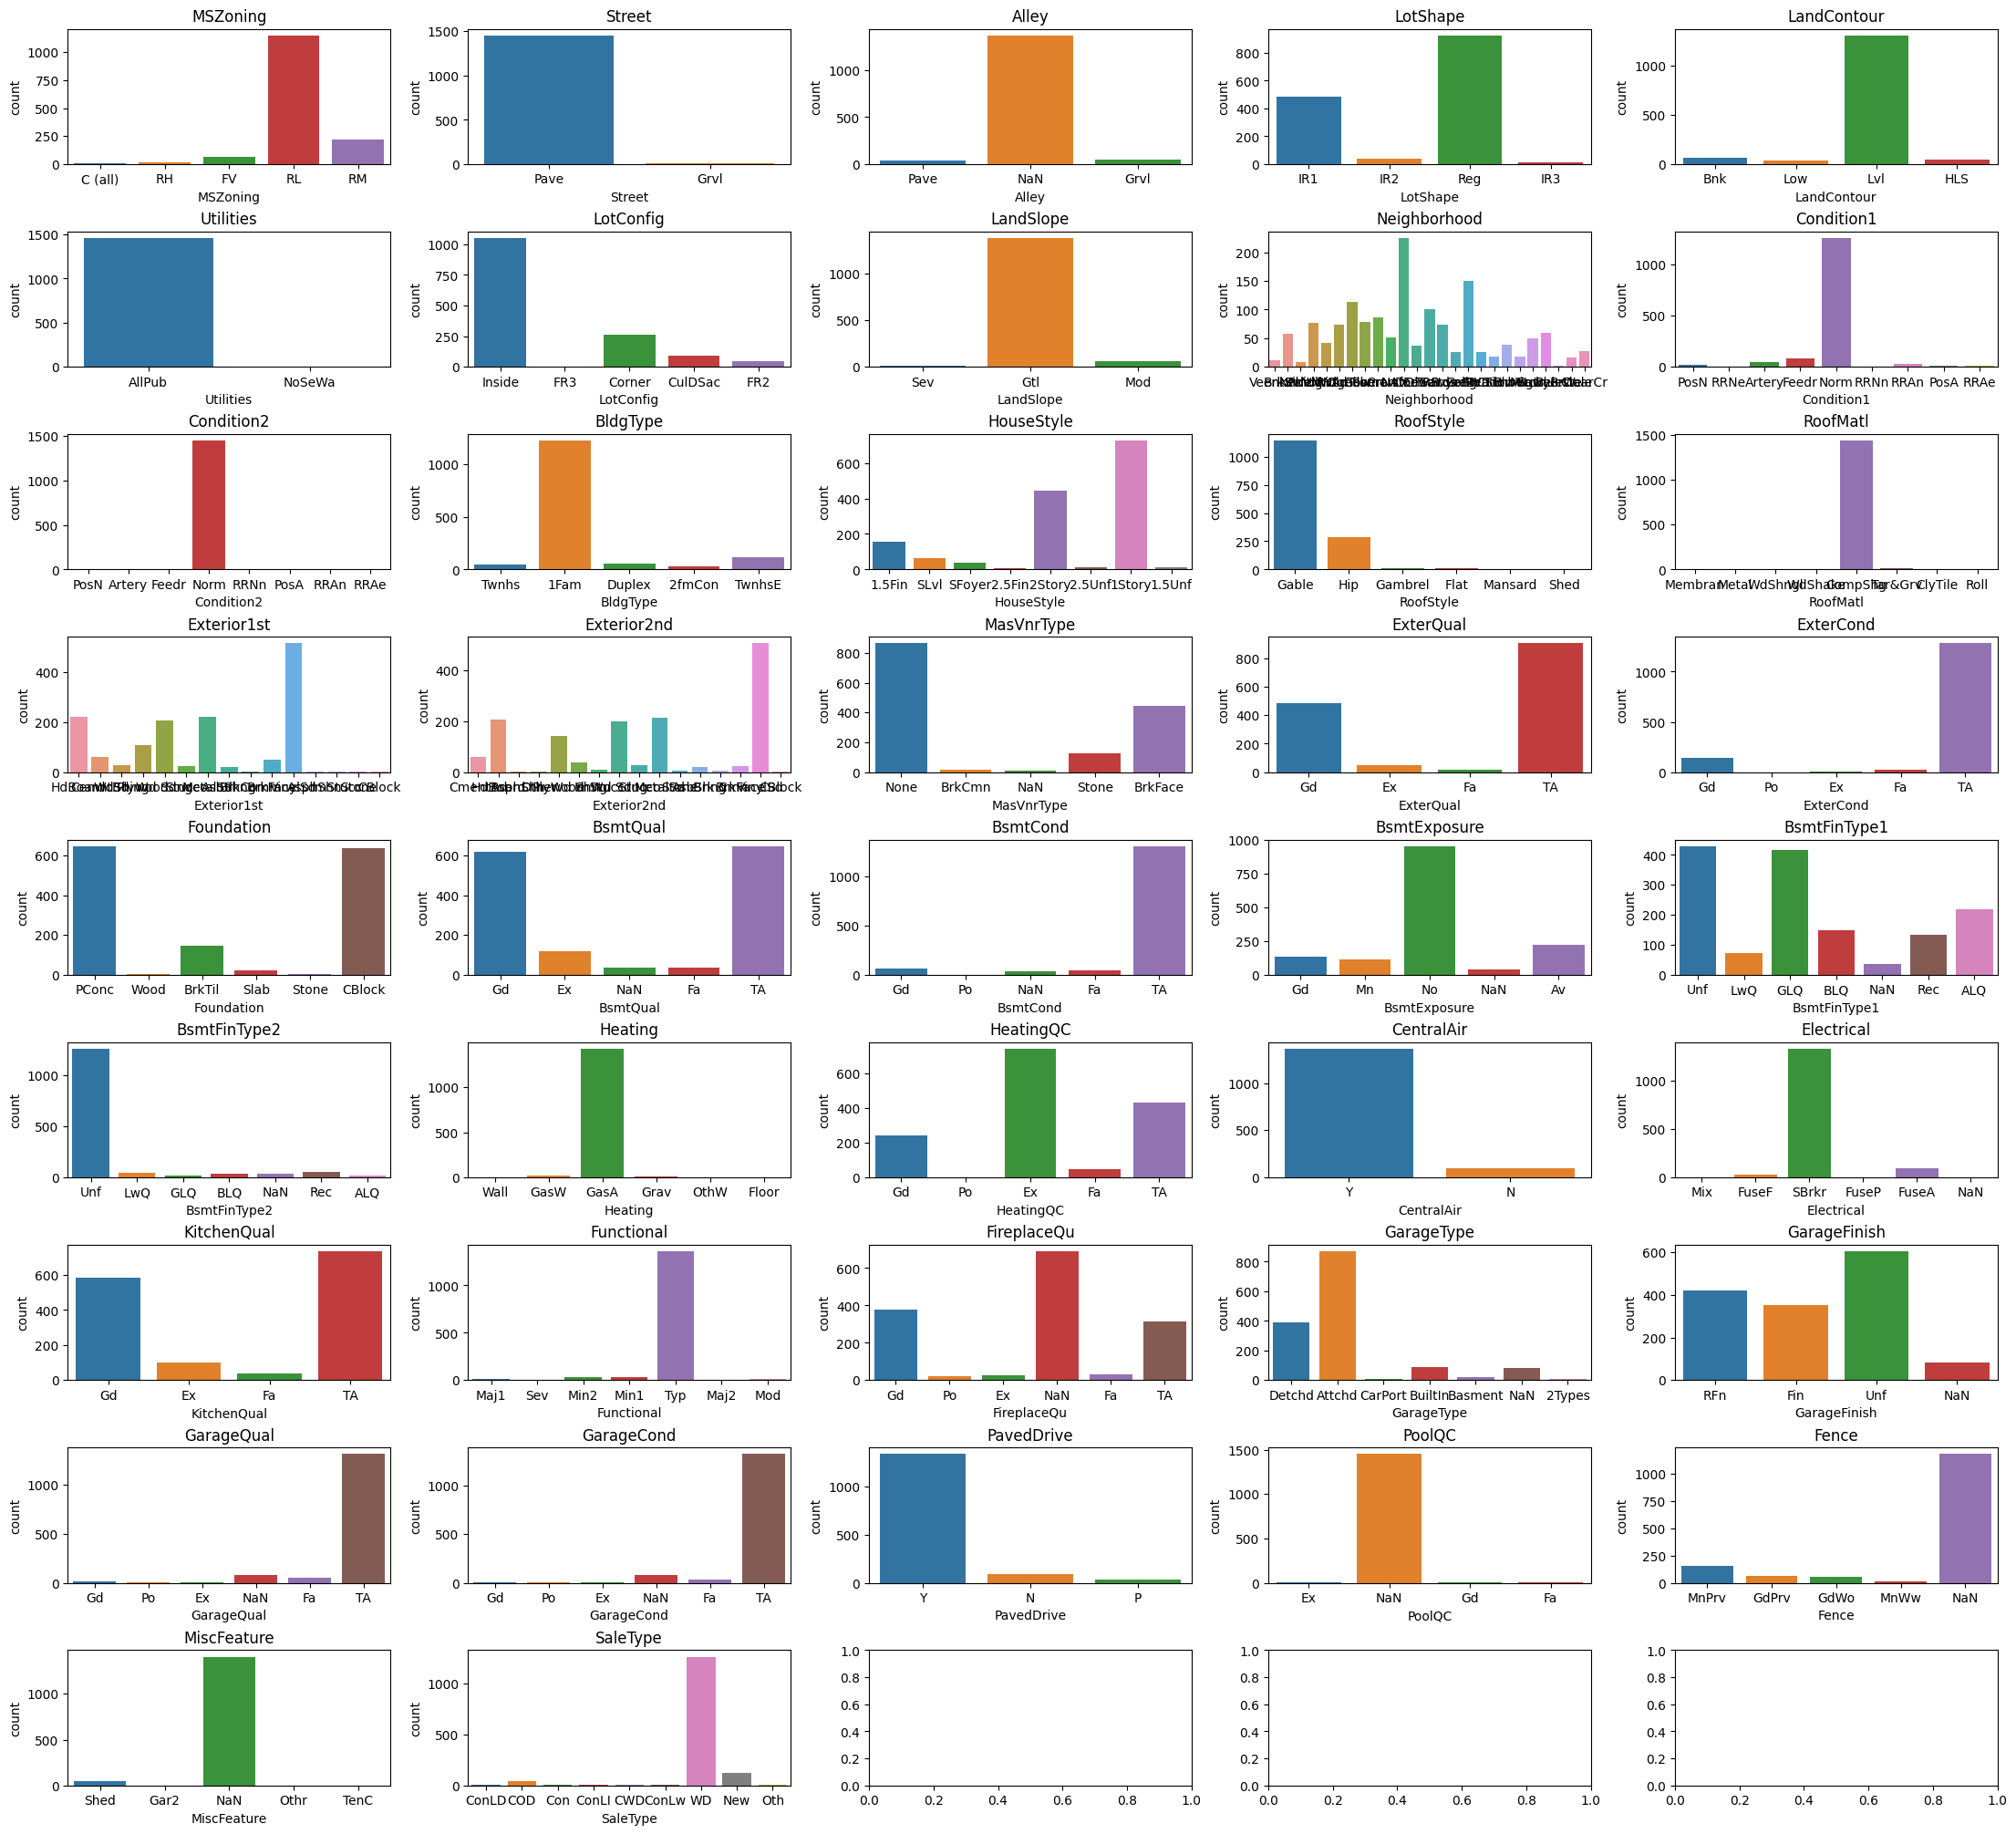

In [ ]:
columnList = [item[0] for item in train_df.dtypes if item[1].startswith('string')]

fig,ax = plt.subplots(nrows=9,ncols=5,figsize=(22,20),constrained_layout=True)
fig.subplots_adjust(hspace=2)

idx, jdx = 0, 0
for arg in columnList:
    categorical_df = train_df.groupBy(arg).count().toPandas()
    sns.barplot(x=arg,y="count",data=categorical_df,ax=ax[jdx][idx])
    ax[jdx,idx].set_title(arg)
    if idx == 4:
        jdx += 1
        idx = 0
    else:
        idx +=1

Variable street, PoolQC, Heating, BsmtFinType2, Condition2,RoofMati,Utilites, and Alley seem to have less influence

In [ ]:
# Remove Feature which is indiscriminate from categorical variable
#cat_minus_col = ['Street', 'PoolQC', 'Heating', 'BsmtFinType2', 'Condition2','RoofMati','Utilites', 'Alley']
cat_plus_col = ['LotFrontage','LotArea','OverallQual','MasVnrArea','BsmtFinSF1','TotalBsmtSF','1stFirSF','GrLivArea','TotRmsAbvGrd','GarageYrBlt','GarageArea','WoodDeckSF','OpenPorchSF','2ndFirSF','YearBuilt','YearRemodAdd']
#train_cat_col = [x for x in columnList if x not in cat_minus_col]
train_cat_col = [x for x in columnList if x in cat_plus_col]
cat_minus_col = [x for x in columnList if x not in cat_plus_col]
#train_cat_col[:3]

In [ ]:
train_df = train_df.drop(*cat_minus_col)

In [ ]:
train_cat_col_ = [x+"_" for x in train_cat_col]

# Summary
- Variable 'LotArea' and 'WoodDeckSF' seem to have high correlation with SalePrice

- 'Street', 'PoolQC', 'Heating', 'BsmtFinType2', 'Condition2','RoofMati','Utilites', 'Alley' can be excluded from the training model. The other variables can be used for training

- The new houses (after Year 2000) tend to have higher SalePrice, but old houses (before Year 1900) that are remodeled with some additional condition also have high SalePrice

## **Predict**

In [ ]:
stringIndex = StringIndexer(inputCols=train_cat_col, 
                       outputCols=train_cat_col_)

stringIndex_model = stringIndex.fit(train_df)

train_df_ = stringIndex_model.transform(train_df).drop(*train_cat_col)
train_df_.toPandas().head(4)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleCondition,SalePrice,Built_Remod
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,0,0,2,2008,0.0,208500,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,0,0,5,2007,0.0,181500,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,0,0,9,2008,0.0,223500,1
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,272,0,0,0,0,2,2006,1.0,140000,55


In [ ]:
train_df_ = train_df_.fillna(0)

In [ ]:
vec_col = train_df_.drop("Id","SalePrice").columns
vec_asmbl = VectorAssembler(inputCols=vec_col, 
                           outputCol='features')

train_df_ = vec_asmbl.transform(train_df_).select('features', 'SalePrice')
train_df_.show(4, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|features                                                                                                                                                                                                  |SalePrice|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|[60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,150.0,856.0,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,8.0,0.0,2003.0,2.0,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,0.0,0.0]              |208500   |
|(38,[0,1,2,3,4,5,6,8,10,11,12,15,17,18,20,21,22,23,24,25,26,27,34,35],[20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,978.0,284.0,1262.0,1262.0,126

In [ ]:
train_data, test_data = train_df_.randomSplit([.8,.2], seed=42)

In [ ]:
lr = LinearRegression(labelCol='SalePrice', featuresCol = 'features', predictionCol = 'resultPrice', 
                      maxIter=10, regParam=0.3, elasticNetParam=0.8, standardization=False)

model = lr.fit(train_data)

In [ ]:
predictions = model.transform(test_data)

In [ ]:
predict_result = predictions.select("resultPrice", "SalePrice")

In [ ]:
predict_result.show()

+------------------+---------+
|       resultPrice|SalePrice|
+------------------+---------+
|108410.33248268126|   106000|
|110439.76782673504|    94750|
| 185947.2620150277|   153500|
|247458.85613678175|   206300|
| 225151.1303682871|   220000|
|199562.70400417445|   185500|
|136175.49624776246|    89471|
|126834.51348903612|   124000|
| 165896.2982892875|   130000|
|136916.99923266168|   131500|
| 145836.9251231621|   124500|
|164496.90587190166|   110000|
|126414.22592283948|   126500|
| 267639.1142297463|   255500|
|205237.10332916665|   191000|
|137268.70083535765|   137500|
| 90154.44332564308|   115000|
|259946.79222784436|   392000|
|164453.74462938646|   142500|
|212695.78782988212|   192000|
+------------------+---------+
only showing top 20 rows



In [ ]:
predict_result = predict_result.withColumn("resultPrice",predict_result.resultPrice.cast("int"))
predict_result.show()

+-----------+---------+
|resultPrice|SalePrice|
+-----------+---------+
|     108410|   106000|
|     110439|    94750|
|     185947|   153500|
|     247458|   206300|
|     225151|   220000|
|     199562|   185500|
|     136175|    89471|
|     126834|   124000|
|     165896|   130000|
|     136916|   131500|
|     145836|   124500|
|     164496|   110000|
|     126414|   126500|
|     267639|   255500|
|     205237|   191000|
|     137268|   137500|
|      90154|   115000|
|     259946|   392000|
|     164453|   142500|
|     212695|   192000|
+-----------+---------+
only showing top 20 rows



In [ ]:
result_df = predict_result.toPandas()
mean_absolute_error(result_df.resultPrice, result_df.SalePrice)

24872.538745387454

In [ ]:
print("MAE: {0}".format(model.summary.meanAbsoluteError))

MAE: 20394.039705235704


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="resultPrice", labelCol="SalePrice",metricName="r2")
print("R Squared (R2) on val data = %g" % lr_evaluator.evaluate(result_df))

AttributeError: ignored